# MLOps End to End Workflow

Implementation of an end-to-end ML Ops workflow for the use case to detect fraudulent credit card transactions, see [Kaggle dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).

This notebook covers:

1. Set up: Creation of the Vertex Dataset, extraction of the schema
1. Implementation of a TFX pipeline
1. Deployment of the Vertex AI Pipeline through a CI/CD process
1. Deployment of a Continuous Training pipeline that can be triggered via Pub/Sub and produces a model in the Model Registry
1. Deployment of the Inference Pipeline consisting of a Cloud Function that retrieves features from Feature Store and calls the model on a Vertex AI Endpoint
1. Deployment of the model to a Vertex AI Endpoint through a CI/CD process.



## Setup

### Package installations

Run 

```
pip install --user -r requirements.txt
```

If an error occurs later, upon importing `tensorflow` related to `numpy`, this can be fixed with a forced reinstall of numpy:

```
pip install --user numpy==1.21.6 --force-reinstall
```

Moreover, running the end-to-end unit test of the pipeline requires forcing a re-install of `grpcio` and `grpcio-tools`:

```
pip install --user grpcio --no-binary=grpcio --force-reinstall
pip install --user grpcio-tools --no-binary=grpcio-tools --force-reinstall
```



### Load data into BigQuery

We are using the Credit Card Fraud Detection dataset from the Machine Learning Group at the Universite Libre de Bruxelles, available on [Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).

Create a dataset called `vertex_eu` in the `EU` region.

To load the data into BQ, from Cloud Shell:

```
bq load --skip_leading_rows=1 vertex_eu.creditcards gs://cxb1-prj-test-no-vpcsc/csv/creditcard.csv Time:STRING,V1:FLOAT,V2:FLOAT,V3:FLOAT,V4:FLOAT,V5:FLOAT,V6:FLOAT,V7:FLOAT,V8:FLOAT,V9:FLOAT,V10:FLOAT,V11:FLOAT,V12:FLOAT,V13:FLOAT,V14:FLOAT,V15:FLOAT,V16:FLOAT,V17:FLOAT,V18:FLOAT,V19:FLOAT,V20:FLOAT,V21:FLOAT,V22:FLOAT,V23:FLOAT,V24:FLOAT,V25:FLOAT,V26:FLOAT,V27:FLOAT,V28:FLOAT,Amount:FLOAT,Class:STRING
```

### Import Libraries


In [15]:
#%load_ext autoreload
#%autoreload 2

import os
import pandas as pd
import tensorflow as tf
import tensorflow_data_validation as tfdv
from google.cloud import bigquery
import matplotlib.pyplot as plt

from google.cloud import aiplatform as vertex_ai

import yaml
import os

In [16]:
with open('mainconfig.yaml') as f:
    main_config = yaml.safe_load(f)

# select your config    
#main_config = main_config['pbalm-google']
main_config = main_config['caixa-novpcsc']

### Configuration

In [17]:
PROJECT = main_config['project'] 
REGION = main_config['region'] 

SERVICE_ACCOUNT = main_config['service_account']

# BigQuery and data locations

BQ_SOURCE_TABLE= main_config['bq']['source_table'] # raw input
ML_TABLE = main_config['bq']['ml_table'] # the one we will use for the training

BQ_DATASET_NAME = main_config['bq']['dataset']
BQ_LOCATION = main_config['bq']['location'] # multiregion provides more resilience

VERTEX_DATASET_NAME = main_config['vertex_dataset_name']

RAW_SCHEMA_DIR = main_config['raw_schema_dir']

BUCKET =  main_config['bucket']

# TFX and model config

# model version
VERSION = main_config['version']


MODEL_DISPLAY_NAME = f'{VERTEX_DATASET_NAME}-classifier-{VERSION}'
WORKSPACE = f'gs://{BUCKET}/{VERTEX_DATASET_NAME}'

MLMD_SQLLITE = 'mlmd.sqllite'
ARTIFACT_STORE = os.path.join(WORKSPACE, 'tfx_artifacts_interactive')
MODEL_REGISTRY = os.path.join(WORKSPACE, 'model_registry')
PIPELINE_NAME = f'{MODEL_DISPLAY_NAME}-train-pipeline'
PIPELINE_ROOT = os.path.join(ARTIFACT_STORE, PIPELINE_NAME)

ENDPOINT_DISPLAY_NAME = f'{VERTEX_DATASET_NAME}-classifier'

FEATURESTORE_ID = main_config['featurestore_id']

CF_REGION = main_config['cloudfunction_region']

DATAFLOW_SUBNETWORK = f"https://www.googleapis.com/compute/v1/projects/{PROJECT}/regions/{REGION}/subnetworks/{main_config['dataflow']['subnet']}"
DATAFLOW_SERVICE_ACCOUNT = main_config['dataflow']['service_account']

CLOUDBUILD_SA = f'projects/{PROJECT}/serviceAccounts/{SERVICE_ACCOUNT}'

LIMIT=main_config['limit']

#### Generate pip configuration

Our containers should install packages from our internal Artifact Registry, rather than try to go to the public PyPI.

In [18]:
pip_conf = f'''[global]
index-url = https://{main_config['artifactregistry_region']}-python.pkg.dev/{PROJECT}/{main_config['python_pkg_repo']}/simple/
timeout=10
'''

with open('build/pip.conf', 'w') as f:
    f.write(pip_conf)

In [19]:
print("Project ID:", PROJECT)
print("Region:", REGION)

vertex_ai.init(
    project=PROJECT,
    location=REGION
)

Project ID: cxb1-prj-test-no-vpcsc
Region: europe-west4


In [20]:
os.environ["VERTEX_DATASET_NAME"] = VERTEX_DATASET_NAME
os.environ["MODEL_DISPLAY_NAME"] = MODEL_DISPLAY_NAME
os.environ["PIPELINE_NAME"] = PIPELINE_NAME
os.environ["PROJECT"] = PROJECT
os.environ['GOOGLE_CLOUD_PROJECT'] = PROJECT
os.environ["REGION"] = REGION
os.environ["GCS_LOCATION"] = f"gs://{BUCKET}/{VERTEX_DATASET_NAME}"
os.environ["MODEL_REGISTRY_URI"] = os.path.join(os.environ["GCS_LOCATION"], "model_registry")
os.environ["TRAIN_LIMIT"] = "85000"
os.environ["TEST_LIMIT"] = "15000"
os.environ["BEAM_RUNNER"] = "DataflowRunner"
os.environ["TRAINING_RUNNER"] = "vertex"
os.environ["TFX_IMAGE_URI"] = f"{REGION}-docker.pkg.dev/{PROJECT}/{VERTEX_DATASET_NAME}/vertex:latest"
os.environ["ENABLE_CACHE"] = "1"
os.environ["SUBNETWORK"] = DATAFLOW_SUBNETWORK
os.environ["SERVICE_ACCOUNT"] = DATAFLOW_SERVICE_ACCOUNT
os.environ["BQ_LOCATION"] = BQ_LOCATION
os.environ["BQ_DATASET_NAME"] = BQ_DATASET_NAME
os.environ["ML_TABLE"] = ML_TABLE
os.environ["GCS_LOCATION"] = f"gs://{BUCKET}/{VERTEX_DATASET_NAME}/e2e_tests"
os.environ["SUBNETWORK"] = DATAFLOW_SUBNETWORK

# Generate ML data

We add a `ML_use` column for pre-splitting the data, where 80% of the datsa items are set to `UNASSIGNED` while the other 20% is set to `TEST`.
This column is used during training to split the dataset for training and test.

In the training phase, the `UNASSIGNED` are split into `train` and `eval`. The `TEST` split is will be used for the final model validation.

In [13]:
sql_script = f'''
CREATE OR REPLACE TABLE `{PROJECT}.{BQ_DATASET_NAME}.{ML_TABLE}` 
AS (
    SELECT
      * EXCEPT(Class),
      CAST(Class AS FLOAT64) as Class,
      IF(ABS(MOD(FARM_FINGERPRINT(Time), 100)) <= 80, 'UNASSIGNED', 'TEST') AS ML_use
    FROM
      `{PROJECT}.{BQ_DATASET_NAME}.{BQ_SOURCE_TABLE}`
)
'''

bq_client = bigquery.Client(project=PROJECT, location=BQ_LOCATION)
job = bq_client.query(sql_script)
#job.result()

# Data Exploration

In [14]:
from google.cloud import bigquery

client = bigquery.Client(project=PROJECT)  

# I use the ML table here and I exclude the TIME and ML_USE columns, because I will later use this sample data to generate
# the schema for the training
sql = f"SELECT * EXCEPT(time, ml_use) FROM `{PROJECT}.{BQ_DATASET_NAME}.{ML_TABLE}` LIMIT 1000"
print(sql)

query_job = client.query(sql, location=BQ_LOCATION)
sample_data = query_job.result().to_dataframe()

SELECT * EXCEPT(time, ml_use) FROM `cxb1-prj-test-no-vpcsc.vertex_eu.creditcards_ml` LIMIT 1000


In [15]:
sample_data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-2.124347,-0.088218,0.790238,3.207753,3.030001,1.358073,0.759941,0.472682,-2.295062,0.965874,...,-0.028968,0.360084,0.814931,-1.687168,1.040174,0.445021,0.097742,-0.140581,0.0,0.0
1,-2.124347,-0.088218,0.790238,3.207753,3.030001,1.358073,0.759941,0.472682,-2.295062,0.965874,...,-0.028968,0.360084,0.814931,-1.687168,1.040174,0.445021,0.097742,-0.140581,0.0,0.0
2,2.133055,0.260351,-2.349379,0.503494,0.765070,-1.626142,0.978525,-0.609256,-0.183323,0.269580,...,0.282448,0.975758,-0.097787,1.245899,0.651528,0.664718,-0.128051,-0.082911,0.0,0.0
3,2.133055,0.260351,-2.349379,0.503494,0.765070,-1.626142,0.978525,-0.609256,-0.183323,0.269580,...,0.282448,0.975758,-0.097787,1.245899,0.651528,0.664718,-0.128051,-0.082911,0.0,0.0
4,-4.943201,3.074877,-1.469630,-1.272718,-2.126654,-1.677141,-1.432828,2.410594,0.761099,0.764233,...,-0.210422,-0.649044,0.104534,0.603918,-0.061980,0.659775,0.129711,-0.007914,0.0,0.0


In [16]:
%%bigquery counts --project {PROJECT} 

SELECT 
  Class, count(*) as n
FROM `vertex_eu.creditcards`
GROUP BY Class

Downloading: 100%|██████████| 2/2 [00:01<00:00,  1.16rows/s]


<AxesSubplot:xlabel='Class'>

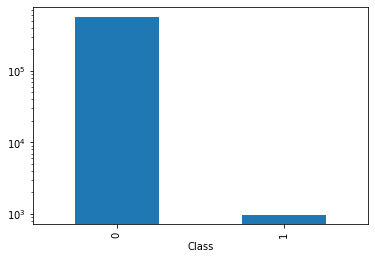

In [17]:
counts.plot(kind='bar', x='Class', y='n', logy=True, legend=False)

<AxesSubplot:>

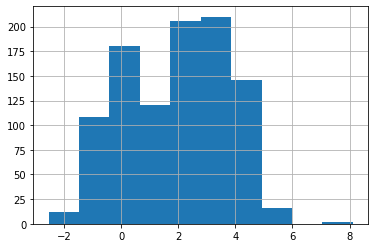

In [18]:
sample_data.V4.hist()

In [19]:
%%bigquery --project {PROJECT}

SELECT ML_use, Class, COUNT(*) as n
FROM vertex_eu.creditcards_ml
GROUP BY ML_use, Class

Downloading: 100%|██████████| 4/4 [00:01<00:00,  2.47rows/s]


,ML_use,Class,n
0,UNASSIGNED,0.0,461820
1,TEST,0.0,106810
2,UNASSIGNED,1.0,804
3,TEST,1.0,180


# Generate Schema


The [TensorFlow Data Validation (TFDV)](https://www.tensorflow.org/tfx/data_validation/get_started) data schema will be used in:
1. Identify the raw data types and shapes in the data transformation.
2. Create the serving input signature for the custom model.
3. Validate the new raw training data in the TFX pipeline.

In [20]:
stats = tfdv.generate_statistics_from_dataframe(
    dataframe=sample_data,
    stats_options=tfdv.StatsOptions(
        label_feature='Class',
        weight_feature=None,
        sample_rate=1,
        num_top_values=50
    )
)

In [21]:
tfdv.visualize_statistics(stats)

In [22]:
schema = tfdv.infer_schema(statistics=stats)
tfdv.display_schema(schema=schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'V1',FLOAT,required,,-
'V2',FLOAT,required,,-
'V3',FLOAT,required,,-
'V4',FLOAT,required,,-
'V5',FLOAT,required,,-
'V6',FLOAT,required,,-
'V7',FLOAT,required,,-
'V8',FLOAT,required,,-
'V9',FLOAT,required,,-


In [23]:
raw_schema_location = os.path.join(RAW_SCHEMA_DIR, 'schema.pbtxt')
tfdv.write_schema_text(schema, raw_schema_location)

# Create Vertex Dataset

In [24]:
bq_uri = f"bq://{PROJECT}.{BQ_DATASET_NAME}.{ML_TABLE}"

dataset = vertex_ai.TabularDataset.create(
    display_name=VERTEX_DATASET_NAME, bq_source=bq_uri)

dataset.gca_resource

Creating TabularDataset
Create TabularDataset backing LRO: projects/1031952735253/locations/europe-west4/datasets/448420424225652736/operations/2455891711788843008
TabularDataset created. Resource name: projects/1031952735253/locations/europe-west4/datasets/448420424225652736
To use this TabularDataset in another session:
ds = aiplatform.TabularDataset('projects/1031952735253/locations/europe-west4/datasets/448420424225652736')


name: "projects/1031952735253/locations/europe-west4/datasets/448420424225652736"
display_name: "creditcards"
metadata_schema_uri: "gs://google-cloud-aiplatform/schema/dataset/metadata/tabular_1.0.0.yaml"
create_time {
  seconds: 1661509898
  nanos: 312960000
}
update_time {
  seconds: 1661509899
  nanos: 669180000
}
etag: "AMEw9yNIhzPewV-16HC62TEd0zv5RH10h5Z_qIayR0-mOSgl98elVVMTJ_DVY7dnU0hp"
labels {
  key: "aiplatform.googleapis.com/dataset_metadata_schema"
  value: "TABLE"
}
metadata {
  struct_value {
    fields {
      key: "inputConfig"
      value {
        struct_value {
          fields {
            key: "bigquerySource"
            value {
              struct_value {
                fields {
                  key: "uri"
                  value {
                    string_value: "bq://cxb1-prj-test-no-vpcsc.vertex_eu.creditcards_ml"
                  }
                }
              }
            }
          }
        }
      }
    }
  }
}

## Retrieve and inspect the Dataset

In [25]:
dataset = vertex_ai.TabularDataset.list(
    filter=f"display_name={VERTEX_DATASET_NAME}", 
    order_by="update_time")[-1]

print("Dataset resource name:", dataset.resource_name)
print("Dataset BigQuery source:", dataset.gca_resource.metadata['inputConfig']['bigquerySource']['uri'])

Dataset resource name: projects/1031952735253/locations/europe-west4/datasets/448420424225652736
Dataset BigQuery source: bq://cxb1-prj-test-no-vpcsc.vertex_eu.creditcards_ml


# Build the TFX Pipeline

In [26]:
import tfx.v1 as tfx
from tfx.extensions.google_cloud_big_query.example_gen.component import BigQueryExampleGen
from tfx.proto import example_gen_pb2, transform_pb2

import tensorflow as tf
import tensorflow_transform as tft
import tensorflow_data_validation as tfdv
import tensorflow_model_analysis as tfma
from tensorflow_transform.tf_metadata import schema_utils


import ml_metadata as mlmd
from ml_metadata.proto import metadata_store_pb2
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext

import logging
import json

from src.common import features, datasource_utils
from src.model_training import data
from src.tfx_pipelines import components

In [27]:
logging.getLogger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')

print("TFX Version:", tfx.__version__)
print("Tensorflow Version:", tf.__version__)

TFX Version: 1.8.0
Tensorflow Version: 2.8.2


In [28]:
PARENT = f"projects/{PROJECT}/locations/{REGION}"
    
print("Project ID:", PROJECT)
print("Region:", REGION)
print("Bucket name:", BUCKET)
print("Service Account:", SERVICE_ACCOUNT)
print("Vertex API Parent URI:", PARENT)

Project ID: cxb1-prj-test-no-vpcsc
Region: europe-west4
Bucket name: cxb1-prjtest-novpcsc-eu
Service Account: sa-mlops@cxb1-prj-test-no-vpcsc.iam.gserviceaccount.com
Vertex API Parent URI: projects/cxb1-prj-test-no-vpcsc/locations/europe-west4


## Create Interactive TFX Context

In [29]:
REMOVE_ARTIFACTS = True

if tf.io.gfile.exists(ARTIFACT_STORE) and REMOVE_ARTIFACTS:
    print("Removing previous artifacts...")
    tf.io.gfile.rmtree(ARTIFACT_STORE)
    
if tf.io.gfile.exists(MLMD_SQLLITE) and REMOVE_ARTIFACTS:
    print("Deleting previous mlmd.sqllite...")
    tf.io.gfile.rmtree(MLMD_SQLLITE)
    
print(f'Pipeline artifacts directory: {PIPELINE_ROOT}')
print(f'Local metadata SQLlit path: {MLMD_SQLLITE}')

Removing previous artifacts...
Deleting previous mlmd.sqllite...
Pipeline artifacts directory: gs://cxb1-prjtest-novpcsc-eu/creditcards/tfx_artifacts_interactive/creditcards-classifier-v01-train-pipeline
Local metadata SQLlit path: mlmd.sqllite


In [30]:
connection_config = metadata_store_pb2.ConnectionConfig()
connection_config.sqlite.filename_uri = MLMD_SQLLITE
connection_config.sqlite.connection_mode = 3 # READWRITE_OPENCREATE
mlmd_store = mlmd.metadata_store.MetadataStore(connection_config)

context = InteractiveContext(
  pipeline_name=PIPELINE_NAME,
  pipeline_root=PIPELINE_ROOT,
  metadata_connection_config=connection_config
)

### Pipeline step 1: Hyperparameter generation

In [31]:
batch_size = 512

hyperparams_gen = components.hyperparameters_gen(
    num_epochs=5,
    learning_rate=0.001,
    batch_size=batch_size,
    hidden_units='64,64',
    steps_per_epoch=LIMIT // batch_size
)

context.run(hyperparams_gen, enable_cache=False)

ExecutionResult(
    component_id: hyperparameters_gen
    execution_id: 1
    outputs:
        hyperparameters: OutputChannel(artifact_type=HyperParameters, producer_component_id=hyperparameters_gen, output_key=hyperparameters, additional_properties={}, additional_custom_properties={}))

#### Load the output of the component from Cloud Storage to check

In [32]:
gcs_uri_ouput = hyperparams_gen.outputs['hyperparameters'].get()[0].uri
gcs_uri_ouput

'gs://cxb1-prjtest-novpcsc-eu/creditcards/tfx_artifacts_interactive/creditcards-classifier-v01-train-pipeline/hyperparameters_gen/hyperparameters/1'

In [33]:
json.load(
    tf.io.gfile.GFile(
        os.path.join(gcs_uri_ouput, 'hyperparameters.json')
    )
)

{'num_epochs': 5,
 'steps_per_epoch': 9,
 'batch_size': 512,
 'learning_rate': 0.001,
 'hidden_units': [64, 64]}

### Pipeline Step 2: Extract data from BQ onto Cloud Storage

In [34]:
def sql_query(ml_use, limit=None):
    return datasource_utils.get_training_source_query(PROJECT, REGION, VERTEX_DATASET_NAME, ml_use=ml_use, limit=limit)

def output_config(splits):
    return example_gen_pb2.Output(
        split_config=example_gen_pb2.SplitConfig(
            splits=[example_gen_pb2.SplitConfig.Split(name=split_name, hash_buckets=buckets) for (split_name, buckets) in splits]
        )
    )

train_example_gen = BigQueryExampleGen(query=sql_query('UNASSIGNED', LIMIT), output_config=output_config([('train', 4), ('eval', 1)]))

beam_pipeline_args=[
    f"--project={PROJECT}",
    f"--temp_location={os.path.join(WORKSPACE, 'tmp')}"
]

context.run(
    train_example_gen,
    beam_pipeline_args=beam_pipeline_args,
    enable_cache=False
)

/home/jupyter/.local/lib/python3.7/site-packages/apache_beam/io/gcp/bigquery.py:2471: BeamDeprecationWarning: options is deprecated since First stable release. References to <pipeline>.options will not be supported
  temp_location = pcoll.pipeline.options.view_as(


ExecutionResult(
    component_id: BigQueryExampleGen
    execution_id: 2
    outputs:
        examples: OutputChannel(artifact_type=Examples, producer_component_id=BigQueryExampleGen, output_key=examples, additional_properties={}, additional_custom_properties={}))

In [35]:
test_example_gen = BigQueryExampleGen(query=sql_query('TEST'), output_config=output_config([('test', 1)]))

context.run(
    test_example_gen,
    beam_pipeline_args=beam_pipeline_args,
    enable_cache=False
)

/home/jupyter/.local/lib/python3.7/site-packages/apache_beam/io/gcp/bigquery.py:2471: BeamDeprecationWarning: options is deprecated since First stable release. References to <pipeline>.options will not be supported
  temp_location = pcoll.pipeline.options.view_as(


ExecutionResult(
    component_id: BigQueryExampleGen
    execution_id: 3
    outputs:
        examples: OutputChannel(artifact_type=Examples, producer_component_id=BigQueryExampleGen, output_key=examples, additional_properties={}, additional_custom_properties={}))

#### Read some TFRecords from the training data

In [36]:
import numpy as np

In [37]:
train_uri = os.path.join(train_example_gen.outputs['examples'].get()[0].uri, "Split-train/*")

source_raw_schema = tfdv.load_schema_text(os.path.join(RAW_SCHEMA_DIR, 'schema.pbtxt'))
raw_feature_spec = schema_utils.schema_as_feature_spec(source_raw_schema).feature_spec

In [38]:
def _parse_tf_example(tfrecord):
    return tf.io.parse_single_example(tfrecord, raw_feature_spec)

tfrecord_filenames = tf.data.Dataset.list_files(train_uri)
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")
dataset = dataset.map(_parse_tf_example)

for raw_features in dataset.shuffle(1000).batch(3).take(1):
    for key in raw_features:
        print(f"{key}: {np.squeeze(raw_features[key], -1)}")
    print("")

2022-08-26 10:34:22.325014: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-08-26 10:34:22.325070: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-26 10:34:22.325103: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (d26e8da5cf09): /proc/driver/nvidia/version does not exist
2022-08-26 10:34:22.349727: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in 

Amount: [0. 0. 0.]
Class: [0. 0. 0.]
V1: [-0.4760828  1.9112512  2.2149894]
V10: [1.061809   0.44130993 0.58130294]
V11: [1.1642629 0.5889202 1.0301307]
V12: [-1.7127448   0.02679082 -2.9127622 ]
V13: [ 3.2773864 -1.7856017  1.6064519]
V14: [1.3386159  0.56610465 1.1700863 ]
V15: [-0.77069336  0.31291968 -0.71047467]
V16: [0.60889494 0.65626276 1.8446242 ]
V17: [ 0.44432926 -0.8502757   0.14172594]
V18: [1.2468828  0.9425894  0.18362579]
V19: [ 1.1741225 -0.5625562  0.7120811]
V2: [ 1.773989   -0.29157925 -0.93786025]
V20: [ 0.25276372 -0.3763277  -0.04710155]
V21: [-0.00403926  0.26333407  0.2234887 ]
V22: [0.41463032 0.81458247 0.8825428 ]
V23: [-0.00764934  0.16986465  0.07779874]
V24: [-0.3853244  -0.04717737 -0.18520612]
V25: [-0.8554079  -0.20404278 -0.12982382]
V26: [ 0.20704783 -0.5745802  -0.1013651 ]
V27: [ 0.36007726  0.04590177 -0.02097237]
V28: [ 0.19196747 -0.04456318 -0.0658671 ]
V3: [ 2.127627   -0.1708534  -0.67769814]
V4: [ 4.5075774  1.2457746 -1.0424137]
V5: [-0.224

### Pipeline step 3: Data Validation

Import the schema, generate statistics and validate the statistics against the schema.

In [39]:
schema_importer = tfx.dsl.Importer(
    source_uri=RAW_SCHEMA_DIR,
    artifact_type=tfx.types.standard_artifacts.Schema,
    reimport=False
)

context.run(schema_importer)

ExecutionResult(
    component_id: Importer
    execution_id: 4
    outputs:
        result: Channel(
            type_name: Schema
            artifacts: [Artifact(artifact: id: 4
        type_id: 18
        uri: "src/raw_schema"
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.8.0"
          }
        }
        , artifact_type: id: 18
        name: "Schema"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

Generate statistics

In [40]:
statistics_gen = tfx.components.StatisticsGen(
    examples=train_example_gen.outputs['examples'])
context.run(statistics_gen)

ExecutionResult(
    component_id: StatisticsGen
    execution_id: 5
    outputs:
        statistics: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=StatisticsGen, output_key=statistics, additional_properties={}, additional_custom_properties={}))

In [41]:
!rm -rf {RAW_SCHEMA_DIR}/.ipynb_checkpoints/

Validate statistics against schema

In [42]:
example_validator = tfx.components.ExampleValidator(
    statistics=statistics_gen.outputs['statistics'],
    schema=schema_importer.outputs['result'],
)

context.run(example_validator)

ExecutionResult(
    component_id: ExampleValidator
    execution_id: 6
    outputs:
        anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=ExampleValidator, output_key=anomalies, additional_properties={}, additional_custom_properties={}))

In [43]:
context.show(example_validator.outputs['anomalies'])

### Pipeline Step 4: Data Preprocesing using TFX Transform (TFT)

In [44]:
_transform_module_file = 'src/preprocessing/transformations.py'

transform = tfx.components.Transform(
    examples=train_example_gen.outputs['examples'],
    schema=schema_importer.outputs['result'],
    module_file=_transform_module_file,
    splits_config=transform_pb2.SplitsConfig(
        analyze=['train'], transform=['train', 'eval']),
)

context.run(transform, enable_cache=False)

running bdist_wheel
running build
running build_py
creating build
creating build/lib
copying transformations.py -> build/lib
copying etl.py -> build/lib
installing to /tmp/tmp6a2m42yh
running install
running install_lib
copying build/lib/etl.py -> /tmp/tmp6a2m42yh
copying build/lib/transformations.py -> /tmp/tmp6a2m42yh
running install_egg_info
running egg_info
creating tfx_user_code_Transform.egg-info
writing tfx_user_code_Transform.egg-info/PKG-INFO
writing dependency_links to tfx_user_code_Transform.egg-info/dependency_links.txt
writing top-level names to tfx_user_code_Transform.egg-info/top_level.txt
writing manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
reading manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
writing manifest file 'tfx_user_code_Transform.egg-info/SOURCES.txt'
Copying tfx_user_code_Transform.egg-info to /tmp/tmp6a2m42yh/tfx_user_code_Transform-0.0+6cacead846ec98634394c7e495fdbb8007223db6968e04eb0fe5ba97ac7c715b-py3.7.egg-info
running inst

/home/jupyter/.local/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,


Processing /tmp/tmpciwcg0it/tfx_user_code_Transform-0.0+6cacead846ec98634394c7e495fdbb8007223db6968e04eb0fe5ba97ac7c715b-py3-none-any.whl
Processing /tmp/tmp46jld92j/tfx_user_code_Transform-0.0+6cacead846ec98634394c7e495fdbb8007223db6968e04eb0fe5ba97ac7c715b-py3-none-any.whl
Processing /tmp/tmp5eb15f3f/tfx_user_code_Transform-0.0+6cacead846ec98634394c7e495fdbb8007223db6968e04eb0fe5ba97ac7c715b-py3-none-any.whl


2022-08-26 10:35:32.977631: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


ExecutionResult(
    component_id: Transform
    execution_id: 7
    outputs:
        transform_graph: OutputChannel(artifact_type=TransformGraph, producer_component_id=Transform, output_key=transform_graph, additional_properties={}, additional_custom_properties={})
        transformed_examples: OutputChannel(artifact_type=Examples, producer_component_id=Transform, output_key=transformed_examples, additional_properties={}, additional_custom_properties={})
        updated_analyzer_cache: OutputChannel(artifact_type=TransformCache, producer_component_id=Transform, output_key=updated_analyzer_cache, additional_properties={}, additional_custom_properties={})
        pre_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=pre_transform_schema, additional_properties={}, additional_custom_properties={})
        pre_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=pre_transform_stats, additional_properties={}, additional_custom_properties={})
        post_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=post_transform_schema, additional_properties={}, additional_custom_properties={})
        post_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=post_transform_stats, additional_properties={}, additional_custom_properties={})
        post_transform_anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=Transform, output_key=post_transform_anomalies, additional_properties={}, additional_custom_properties={}))

#### Test: Read an example of the transformed data

In [45]:
transformed_train_uri = os.path.join(transform.outputs['transformed_examples'].get()[0].uri, "Split-train/*")
transform_graph_uri = transform.outputs['transform_graph'].get()[0].uri

tft_output = tft.TFTransformOutput(transform_graph_uri)
transform_feature_spec = tft_output.transformed_feature_spec()

for input_features, target in data.get_dataset(
    transformed_train_uri, transform_feature_spec, batch_size=3, epochs=1).take(1):
    for key in input_features:
        print(f"{key} ({input_features[key].dtype}): {input_features[key].numpy().tolist()}")
    print(f"target: {target.numpy().tolist()}")

Amount (<dtype: 'float32'>): [[-0.8118097186088562], [1.157891869544983], [-0.8118097186088562]]
V1 (<dtype: 'float32'>): [[-0.5542698502540588], [0.6004987359046936], [0.61952805519104]]
V10 (<dtype: 'float32'>): [[-6.489274978637695], [-0.20534181594848633], [-0.12779103219509125]]
V11 (<dtype: 'float32'>): [[3.3997929096221924], [-0.47786521911621094], [1.5054525136947632]]
V12 (<dtype: 'float32'>): [[-6.896195411682129], [0.22863362729549408], [0.14890849590301514]]
V13 (<dtype: 'float32'>): [[-1.4018735885620117], [0.6533915996551514], [-1.39320707321167]]
V14 (<dtype: 'float32'>): [[-9.741106986999512], [0.15416428446769714], [0.7596995830535889]]
V15 (<dtype: 'float32'>): [[0.2523840069770813], [1.7533265352249146], [0.725651741027832]]
V16 (<dtype: 'float32'>): [[-1.8343241214752197], [0.10176768898963928], [-0.020838143303990364]]
V17 (<dtype: 'float32'>): [[-2.9976067543029785], [-0.41193869709968567], [-0.1034460961818695]]
V18 (<dtype: 'float32'>): [[0.38273870944976807], [

### Pipeline Step 5: Model Training

In [46]:
from tfx.dsl.components.common.resolver import Resolver
from tfx.dsl.experimental import latest_blessed_model_resolver

In [47]:
_train_module_file = 'src/model_training/runner.py'

trainer = tfx.components.Trainer(
    module_file=_train_module_file,
    examples=transform.outputs['transformed_examples'],
    schema=schema_importer.outputs['result'],
    transform_graph=transform.outputs['transform_graph'],
    hyperparameters=hyperparams_gen.outputs['hyperparameters'],
)

context.run(trainer, enable_cache=False)

running bdist_wheel
running build
running build_py
creating build
creating build/lib
copying model.py -> build/lib
copying data.py -> build/lib
copying trainer.py -> build/lib
copying exporter.py -> build/lib
copying defaults.py -> build/lib
copying runner.py -> build/lib
installing to /tmp/tmpjplr798l
running install
running install_lib
copying build/lib/exporter.py -> /tmp/tmpjplr798l
copying build/lib/model.py -> /tmp/tmpjplr798l
copying build/lib/runner.py -> /tmp/tmpjplr798l
copying build/lib/data.py -> /tmp/tmpjplr798l
copying build/lib/defaults.py -> /tmp/tmpjplr798l
copying build/lib/trainer.py -> /tmp/tmpjplr798l
running install_egg_info
running egg_info
creating tfx_user_code_Trainer.egg-info
writing tfx_user_code_Trainer.egg-info/PKG-INFO
writing dependency_links to tfx_user_code_Trainer.egg-info/dependency_links.txt
writing top-level names to tfx_user_code_Trainer.egg-info/top_level.txt
writing manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
reading manifest file

/home/jupyter/.local/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,


Processing /tmp/tmpx026so77/tfx_user_code_Trainer-0.0+81e005e0e4d48d39ffe694ac912d4701d6b1b337d2d89d18a5448eef972b79db-py3-none-any.whl
Epoch 1/5


/home/jupyter/.local/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


9/9 [==============================] - 8s 467ms/step - loss: 0.6947 - accuracy: 0.5315 - auc: 0.5320 - val_loss: 0.4551 - val_accuracy: 0.9591 - val_auc: 0.3217
Epoch 2/5
9/9 [==============================] - 2s 215ms/step - loss: 0.3645 - accuracy: 0.9822 - auc: 0.0683 - val_loss: 0.2505 - val_accuracy: 0.9902 - val_auc: 0.0062
Epoch 3/5
9/9 [==============================] - 2s 207ms/step - loss: 0.2187 - accuracy: 0.9894 - auc: 0.0058 - val_loss: 0.1532 - val_accuracy: 0.9903 - val_auc: 0.0061
Epoch 4/5
9/9 [==============================] - 2s 214ms/step - loss: 0.1434 - accuracy: 0.9891 - auc: 0.0065 - val_loss: 0.0990 - val_accuracy: 0.9902 - val_auc: 0.0106
Epoch 5/5
9/9 [==============================] - 2s 214ms/step - loss: 0.0982 - accuracy: 0.9889 - auc: 0.0697 - val_loss: 0.0649 - val_accuracy: 0.9902 - val_auc: 0.5826


ExecutionResult(
    component_id: Trainer
    execution_id: 8
    outputs:
        model: OutputChannel(artifact_type=Model, producer_component_id=Trainer, output_key=model, additional_properties={}, additional_custom_properties={})
        model_run: OutputChannel(artifact_type=ModelRun, producer_component_id=Trainer, output_key=model_run, additional_properties={}, additional_custom_properties={}))

### Pipeline Step 6: Model Evaluation

#### Get the latest blessed model for model validation

In [48]:
blessed_model_resolver = Resolver(
    strategy_class=latest_blessed_model_resolver.LatestBlessedModelResolver,
    model=tfx.dsl.Channel(type=tfx.types.standard_artifacts.Model),
    model_blessing=tfx.dsl.Channel(type=tfx.types.standard_artifacts.ModelBlessing)
)

context.run(blessed_model_resolver, enable_cache=False)

ExecutionResult(
    component_id: Resolver
    execution_id: 9
    outputs:
        model: OutputChannel(artifact_type=Model, producer_component_id=Resolver, output_key=model, additional_properties={}, additional_custom_properties={})
        model_blessing: OutputChannel(artifact_type=ModelBlessing, producer_component_id=Resolver, output_key=model_blessing, additional_properties={}, additional_custom_properties={}))

#### Evaluate the model and compare against the baseline

In [49]:
from tfx.components import Evaluator

In [50]:
eval_config = tfma.EvalConfig(
    model_specs=[
        tfma.ModelSpec(
            signature_name='serving_tf_example',
            label_key=features.TARGET_FEATURE_NAME,
            prediction_key='probabilities')
    ],
    slicing_specs=[
        tfma.SlicingSpec(),
    ],
    metrics_specs=[
        tfma.MetricsSpec(
            metrics=[   
                tfma.MetricConfig(class_name='ExampleCount'),
                tfma.MetricConfig(
                    class_name='BinaryAccuracy',
                    threshold=tfma.MetricThreshold(
                        value_threshold=tfma.GenericValueThreshold(
                            lower_bound={'value': 0.1}), ## note setting a very low barrier for this example
                        # Change threshold will be ignored if there is no
                        # baseline model resolved from MLMD (first run).
                        change_threshold=tfma.GenericChangeThreshold(
                            direction=tfma.MetricDirection.HIGHER_IS_BETTER,
                            absolute={'value': -1e-10}))),
        ])
    ])


evaluator = Evaluator(
    examples=test_example_gen.outputs['examples'],
    example_splits=['test'],
    model=trainer.outputs['model'],
    baseline_model=blessed_model_resolver.outputs['model'],
    eval_config=eval_config,
    schema=schema_importer.outputs['result']
)

context.run(evaluator, enable_cache=False)

ExecutionResult(
    component_id: Evaluator
    execution_id: 10
    outputs:
        evaluation: OutputChannel(artifact_type=ModelEvaluation, producer_component_id=Evaluator, output_key=evaluation, additional_properties={}, additional_custom_properties={})
        blessing: OutputChannel(artifact_type=ModelBlessing, producer_component_id=Evaluator, output_key=blessing, additional_properties={}, additional_custom_properties={}))

In [51]:
evaluation_results = evaluator.outputs['evaluation'].get()[0].uri
print("validation_ok:", tfma.load_validation_result(evaluation_results).validation_ok, '\n')

for entry in list(tfma.load_metrics(evaluation_results))[0].metric_keys_and_values:
    value = entry.value.double_value.value
    if value:
        print(entry.key.name, ":", round(entry.value.double_value.value, 3))

validation_ok: True 

accuracy : 0.543
auc : 0.077
loss : 0.975
example_count : 106990.0
binary_accuracy : 0.543


### Pipeline Step 7: Push model to Cloud Storage

In [52]:
exported_model_location = os.path.join(MODEL_REGISTRY, MODEL_DISPLAY_NAME)

push_destination=tfx.proto.PushDestination(
    filesystem=tfx.proto.PushDestination.Filesystem(
        base_directory=exported_model_location,
    )
)

pusher = tfx.components.Pusher(
    model=trainer.outputs['model'],
    model_blessing=evaluator.outputs['blessing'],
    push_destination=push_destination
)

context.run(pusher, enable_cache=False)

ExecutionResult(
    component_id: Pusher
    execution_id: 11
    outputs:
        pushed_model: OutputChannel(artifact_type=PushedModel, producer_component_id=Pusher, output_key=pushed_model, additional_properties={}, additional_custom_properties={}))

### Pipeline Step 8: Upload model to Vertex AI

In [53]:
serving_runtime = 'tf2-cpu.2-5'
serving_image_uri = f"europe-docker.pkg.dev/vertex-ai/prediction/{serving_runtime}:latest"

labels = {
    'dataset_name': VERTEX_DATASET_NAME,
    'pipeline_name': PIPELINE_NAME
}
labels = json.dumps(labels)

vertex_model_uploader = components.vertex_model_uploader(
    project=PROJECT,
    region=REGION,
    model_display_name=MODEL_DISPLAY_NAME,
    pushed_model_location=exported_model_location,
    serving_image_uri=serving_image_uri,
    model_blessing=evaluator.outputs['blessing'],
    explanation_config='',
    labels=labels
)

context.run(vertex_model_uploader, enable_cache=False)

Creating Model


INFO:google.cloud.aiplatform.models:Creating Model


Create Model backing LRO: projects/1031952735253/locations/europe-west4/models/3074841441680228352/operations/3338597238753460224


INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/1031952735253/locations/europe-west4/models/3074841441680228352/operations/3338597238753460224


Model created. Resource name: projects/1031952735253/locations/europe-west4/models/3074841441680228352@1


INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/1031952735253/locations/europe-west4/models/3074841441680228352@1


To use this Model in another session:


INFO:google.cloud.aiplatform.models:To use this Model in another session:


model = aiplatform.Model('projects/1031952735253/locations/europe-west4/models/3074841441680228352@1')


INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/1031952735253/locations/europe-west4/models/3074841441680228352@1')


ExecutionResult(
    component_id: vertex_model_uploader
    execution_id: 12
    outputs:
        uploaded_model: OutputChannel(artifact_type=File, producer_component_id=vertex_model_uploader, output_key=uploaded_model, additional_properties={}, additional_custom_properties={}))

In [54]:
vertex_model_uploader.outputs['uploaded_model'].get()[0].uri

'gs://cxb1-prjtest-novpcsc-eu/creditcards/tfx_artifacts_interactive/creditcards-classifier-v01-train-pipeline/vertex_model_uploader/uploaded_model/12'

## Unit Testing

In [55]:
os.environ["UPLOAD_MODEL"] = "0"
os.environ["ACCURACY_THRESHOLD"] = "-0.1"    # NB Negative accuracy threshold makes no sense - allows everything
os.environ["BEAM_RUNNER"] = "DirectRunner"
os.environ["TRAINING_RUNNER"] = "local"

In [56]:
from src.tfx_pipelines import config
import importlib
importlib.reload(config)

for key, value in config.__dict__.items():
    if key.isupper(): print(f'{key}: {value}')

PROJECT: cxb1-prj-test-no-vpcsc
REGION: europe-west4
GCS_LOCATION: gs://cxb1-prjtest-novpcsc-eu/creditcards/e2e_tests
ARTIFACT_STORE_URI: gs://cxb1-prjtest-novpcsc-eu/creditcards/e2e_tests/tfx_artifacts
MODEL_REGISTRY_URI: gs://cxb1-prjtest-novpcsc-eu/creditcards/model_registry
VERTEX_DATASET_NAME: creditcards
MODEL_DISPLAY_NAME: creditcards-classifier-v01
PIPELINE_NAME: creditcards-classifier-v01-train-pipeline
ML_USE_COLUMN: ml_use
EXCLUDE_COLUMNS: trip_start_timestamp
TRAIN_LIMIT: 85000
TEST_LIMIT: 15000
SERVE_LIMIT: 0
NUM_TRAIN_SPLITS: 4
NUM_EVAL_SPLITS: 1
ACCURACY_THRESHOLD: -0.1
USE_KFP_SA: False
TFX_IMAGE_URI: europe-west4-docker.pkg.dev/cxb1-prj-test-no-vpcsc/creditcards/vertex:latest
BEAM_RUNNER: DirectRunner
SERVICE_ACCOUNT: sa-mlops@cxb1-prj-test-no-vpcsc.iam.gserviceaccount.com
SUBNETWORK: https://www.googleapis.com/compute/v1/projects/cxb1-prj-test-no-vpcsc/regions/europe-west4/subnetworks/default
BEAM_DIRECT_PIPELINE_ARGS: ['--project=cxb1-prj-test-no-vpcsc', '--temp_loca

In [57]:
!python -m pytest src/tests/datasource_utils_tests.py -s

============================= test session starts ==============================
platform linux -- Python 3.7.12, pytest-7.1.2, pluggy-1.0.0
rootdir: /home/jupyter/prjtest-novpcsc/mlops-creditcard
plugins: anyio-3.6.1
collected 2 items                                                              

src/tests/datasource_utils_tests.py BigQuery Source: cxb1-prj-test-no-vpcsc.vertex_eu.creditcards_ml
.BigQuery Source: cxb1-prj-test-no-vpcsc.vertex_eu.creditcards_ml
.

============================== 2 passed in 8.84s ===============================


In [58]:
!python -m pytest src/tests/model_tests.py -s

============================= test session starts ==============================
platform linux -- Python 3.7.12, pytest-7.1.2, pluggy-1.0.0
rootdir: /home/jupyter/prjtest-novpcsc/mlops-creditcard
plugins: anyio-3.6.1
collected 2 items                                                              

src/tests/model_tests.py .2022-08-26 10:39:24.966575: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-08-26 10:39:24.966626: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-26 10:39:24.966656: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (d

#### End to end pipeline unit test

In [59]:
!python -m pytest src/tests/pipeline_deployment_tests.py::test_e2e_pipeline -s

E0826 10:39:27.929895458    1259 backup_poller.cc:136]       Run client channel backup poller: {"created":"@1661510367.929736192","description":"pollset_work","file":"src/core/lib/iomgr/ev_epoll1_linux.cc","file_line":247,"referenced_errors":[{"created":"@1661510367.929708462","description":"Bad file descriptor","errno":9,"file":"src/core/lib/iomgr/ev_epoll1_linux.cc","file_line":732,"os_error":"Bad file descriptor","syscall":"epoll_wait"}]}
============================= test session starts ==============================
platform linux -- Python 3.7.12, pytest-7.1.2, pluggy-1.0.0
rootdir: /home/jupyter/prjtest-novpcsc/mlops-creditcard
plugins: anyio-3.6.1
collected 1 item                                                               

src/tests/pipeline_deployment_tests.py upload_model: 0
Pipeline e2e test artifacts stored in: gs://cxb1-prjtest-novpcsc-eu/creditcards/e2e_tests
ML metadata store is ready.
Using dataset creditcards
Excluding no splits because exclude_splits is not set.
E

## Deploy to Vertex AI Pipelines

In [21]:
from src.tfx_pipelines import config
import importlib

importlib.reload(config)

for key, value in config.__dict__.items():
    if key.isupper(): print(f'{key}: {value}')

PROJECT: cxb1-prj-test-no-vpcsc
REGION: europe-west4
GCS_LOCATION: gs://cxb1-prjtest-novpcsc-eu/creditcards/e2e_tests
ARTIFACT_STORE_URI: gs://cxb1-prjtest-novpcsc-eu/creditcards/e2e_tests/tfx_artifacts
MODEL_REGISTRY_URI: gs://cxb1-prjtest-novpcsc-eu/creditcards/model_registry
VERTEX_DATASET_NAME: creditcards
MODEL_DISPLAY_NAME: creditcards-classifier-v02
PIPELINE_NAME: creditcards-classifier-v02-train-pipeline
ML_USE_COLUMN: ml_use
EXCLUDE_COLUMNS: trip_start_timestamp
TRAIN_LIMIT: 85000
TEST_LIMIT: 15000
SERVE_LIMIT: 0
NUM_TRAIN_SPLITS: 4
NUM_EVAL_SPLITS: 1
ACCURACY_THRESHOLD: 0.8
USE_KFP_SA: False
TFX_IMAGE_URI: europe-west4-docker.pkg.dev/cxb1-prj-test-no-vpcsc/creditcards/vertex:latest
BEAM_RUNNER: DataflowRunner
SERVICE_ACCOUNT: sa-mlops@cxb1-prj-test-no-vpcsc.iam.gserviceaccount.com
SUBNETWORK: https://www.googleapis.com/compute/v1/projects/cxb1-prj-test-no-vpcsc/regions/europe-west4/subnetworks/default
BEAM_DIRECT_PIPELINE_ARGS: ['--project=cxb1-prj-test-no-vpcsc', '--temp_loc

In [22]:
config.BEAM_RUNNER

'DataflowRunner'

### Create Repo for Images

In [23]:
!echo gcloud artifacts repositories create {VERTEX_DATASET_NAME} --location={REGION} --repository-format=docker

E0826 16:57:37.740983655    1609 backup_poller.cc:136]       Run client channel backup poller: {"created":"@1661533057.740728638","description":"pollset_work","file":"src/core/lib/iomgr/ev_epoll1_linux.cc","file_line":247,"referenced_errors":[{"created":"@1661533057.740721314","description":"Bad file descriptor","errno":9,"file":"src/core/lib/iomgr/ev_epoll1_linux.cc","file_line":732,"os_error":"Bad file descriptor","syscall":"epoll_wait"}]}
gcloud artifacts repositories create creditcards --location=europe-west4 --repository-format=docker


### Build Dataflow Worker Image

In [24]:
!cp build/Dockerfile.dataflow Dockerfile
!echo gcloud builds submit . --tag {REGION}-docker.pkg.dev/{PROJECT}/{VERTEX_DATASET_NAME}/dataflow:latest --timeout=30m --machine-type=e2-highcpu-8 --billing-project=$PROJECT --suppress-logs

gcloud builds submit . --tag europe-west4-docker.pkg.dev/cxb1-prj-test-no-vpcsc/creditcards/dataflow:latest --timeout=30m --machine-type=e2-highcpu-8 --billing-project=cxb1-prj-test-no-vpcsc --suppress-logs


### Build Vertex worker image

In [25]:
!echo $TFX_IMAGE_URI

europe-west4-docker.pkg.dev/cxb1-prj-test-no-vpcsc/creditcards/vertex:latest


In [26]:
!echo $PYTHONPATH

In [27]:
!cp build/Dockerfile.vertex Dockerfile
!echo gcloud builds submit --tag $TFX_IMAGE_URI . --timeout=15m --machine-type=e2-highcpu-8 --billing-project=$PROJECT --suppress-logs --async

gcloud builds submit --tag europe-west4-docker.pkg.dev/cxb1-prj-test-no-vpcsc/creditcards/vertex:latest . --timeout=15m --machine-type=e2-highcpu-8 --billing-project=cxb1-prj-test-no-vpcsc --suppress-logs --async


### Compile the pipeline

In [28]:
from src.tfx_pipelines import config, runner

pipeline_definition_file = f'{config.PIPELINE_NAME}.json'
pipeline_definition = runner.compile_training_pipeline(pipeline_definition_file)

Labels for model: {"dataset_name": "creditcards", "pipeline_name": "creditcards-classifier-v02-train-pipeline", "pipeline_root": "gs://cxb1-prjtest-novpcsc-eu/creditcards/e2e_tests/tfx_artifac"}
running bdist_wheel
running build
running build_py
creating build
creating build/lib
copying transformations.py -> build/lib
copying etl.py -> build/lib
installing to /tmp/tmp5nhnbwse
running install
running install_lib
copying build/lib/etl.py -> /tmp/tmp5nhnbwse
copying build/lib/transformations.py -> /tmp/tmp5nhnbwse
running install_egg_info
running egg_info
creating tfx_user_code_DataTransformer.egg-info
writing tfx_user_code_DataTransformer.egg-info/PKG-INFO
writing dependency_links to tfx_user_code_DataTransformer.egg-info/dependency_links.txt
writing top-level names to tfx_user_code_DataTransformer.egg-info/top_level.txt
writing manifest file 'tfx_user_code_DataTransformer.egg-info/SOURCES.txt'
reading manifest file 'tfx_user_code_DataTransformer.egg-info/SOURCES.txt'
writing manifest fi

/home/jupyter/.local/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,


running bdist_wheel
running build
running build_py
creating build
creating build/lib
copying model.py -> build/lib
copying data.py -> build/lib
copying trainer.py -> build/lib
copying exporter.py -> build/lib
copying defaults.py -> build/lib
copying runner.py -> build/lib
installing to /tmp/tmpf1w238c8
running install
running install_lib
copying build/lib/exporter.py -> /tmp/tmpf1w238c8
copying build/lib/model.py -> /tmp/tmpf1w238c8
copying build/lib/runner.py -> /tmp/tmpf1w238c8
copying build/lib/data.py -> /tmp/tmpf1w238c8
copying build/lib/defaults.py -> /tmp/tmpf1w238c8
copying build/lib/trainer.py -> /tmp/tmpf1w238c8
running install_egg_info
running egg_info
creating tfx_user_code_ModelTrainer.egg-info
writing tfx_user_code_ModelTrainer.egg-info/PKG-INFO
writing dependency_links to tfx_user_code_ModelTrainer.egg-info/dependency_links.txt
writing top-level names to tfx_user_code_ModelTrainer.egg-info/top_level.txt
writing manifest file 'tfx_user_code_ModelTrainer.egg-info/SOURCES.t

/home/jupyter/.local/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,


In [29]:
PIPELINES_STORE = f"gs://{BUCKET}/{VERTEX_DATASET_NAME}/compiled_pipelines/"
!gsutil cp {pipeline_definition_file} {PIPELINES_STORE}

Copying file://creditcards-classifier-v02-train-pipeline.json [Content-Type=application/json]...
/ [1 files][ 33.4 KiB/ 33.4 KiB]                                                
Operation completed over 1 objects/33.4 KiB.                                     


### Submit Vertex AI Pipelines run

In [30]:
from google.cloud.aiplatform import pipeline_jobs
    
job = pipeline_jobs.PipelineJob(template_path = pipeline_definition_file,
                                display_name=VERTEX_DATASET_NAME,
                                #enable_caching=False,
                                parameter_values={
                                    'learning_rate': 0.003,
                                    'batch_size': 512,
                                    'steps_per_epoch': int(config.TRAIN_LIMIT) // 512,
                                    'hidden_units': '128,128',
                                    'num_epochs': 30,
                                })

job.run(sync=False, service_account=DATAFLOW_SERVICE_ACCOUNT)

Creating PipelineJob


INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob


PipelineJob created. Resource name: projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v02-train-pipeline-20220826165821


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v02-train-pipeline-20220826165821


To use this PipelineJob in another session:


INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:


pipeline_job = aiplatform.PipelineJob.get('projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v02-train-pipeline-20220826165821')


INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v02-train-pipeline-20220826165821')


View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/europe-west4/pipelines/runs/creditcards-classifier-v02-train-pipeline-20220826165821?project=1031952735253


INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/europe-west4/pipelines/runs/creditcards-classifier-v02-train-pipeline-20220826165821?project=1031952735253


PipelineJob projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v02-train-pipeline-20220826165821 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v02-train-pipeline-20220826165821 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v02-train-pipeline-20220826165821 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v02-train-pipeline-20220826165821 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v02-train-pipeline-20220826165821 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v02-train-pipeline-20220826165821 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v02-train-pipeline-20220826165821 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v02-train-pipeline-20220826165821 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v02-train-pipeline-20220826165821 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v02-train-pipeline-20220826165821 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v02-train-pipeline-20220826165821 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v02-train-pipeline-20220826165821 current state:
PipelineState.PIPELINE_STATE_RUNNING


## Deploy Continuous Training Pipeline ("CI/CD")

* Deploy Pub/Sub topic to listen to retraining triggers
* Deploy Cloud Function to listen to Pub/Sub topic and trigger Vertex AI Pipeline
* Deploy Vertex AI Pipeline

### Build CI/CD image

In [70]:
CICD_IMAGE_URI = f'{REGION}-docker.pkg.dev/{PROJECT}/{VERTEX_DATASET_NAME}/cicd:latest'
CICD_IMAGE_URI

'europe-west4-docker.pkg.dev/cxb1-prj-test-no-vpcsc/creditcards/cicd:latest'

In [71]:
!cp build/Dockerfile.cicd build/Dockerfile
!echo gcloud builds submit --tag $CICD_IMAGE_URI build/. --timeout=15m --machine-type=e2-highcpu-8 --async --suppress-logs --billing-project {PROJECT} --async

E0826 10:46:47.087490291       1 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


PipelineJob created. Resource name: projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v01-train-pipeline-20220826104647


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v01-train-pipeline-20220826104647


To use this PipelineJob in another session:


INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:


pipeline_job = aiplatform.PipelineJob.get('projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v01-train-pipeline-20220826104647')


INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v01-train-pipeline-20220826104647')


View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/europe-west4/pipelines/runs/creditcards-classifier-v01-train-pipeline-20220826104647?project=1031952735253


INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/europe-west4/pipelines/runs/creditcards-classifier-v01-train-pipeline-20220826104647?project=1031952735253


gcloud builds submit --tag europe-west4-docker.pkg.dev/cxb1-prj-test-no-vpcsc/creditcards/cicd:latest build/. --timeout=15m --machine-type=e2-highcpu-8 --async --suppress-logs --billing-project cxb1-prj-test-no-vpcsc --async


### Automate the deployment of the Training Pipeline using Cloud Build

In [72]:
REPO_URL = main_config['git']['repo_url']
BRANCH = main_config['git']['branch']


GCS_LOCATION = f"gs://{BUCKET}/{VERTEX_DATASET_NAME}/"
TEST_GCS_LOCATION = f"gs://{BUCKET}/{VERTEX_DATASET_NAME}/e2e_tests"
CI_TRAIN_LIMIT = 1000
CI_TEST_LIMIT = 100
CI_UPLOAD_MODEL = 0
CI_ACCURACY_THRESHOLD = -0.1 # again setting accuracy threshold to negative
BEAM_RUNNER = "DataflowRunner"
TRAINING_RUNNER = "vertex"
VERSION = 'latest'
PIPELINE_NAME = f'{MODEL_DISPLAY_NAME}-train-pipeline'
PIPELINES_STORE = os.path.join(GCS_LOCATION, "compiled_pipelines")

TFX_IMAGE_URI = f"{REGION}-docker.pkg.dev/{PROJECT}/{VERTEX_DATASET_NAME}/vertex:{VERSION}"

REPO_NAME = REPO_URL.split('/')[-1]
DESCR=f'"Deploy train pipeline to GCS from {BRANCH}"'


SUBSTITUTIONS=f"""\
_REPO_URL='{REPO_URL}',\
_BRANCH={BRANCH},\
_CICD_IMAGE_URI={CICD_IMAGE_URI},\
_PROJECT={PROJECT},\
_REGION={REGION},\
_GCS_LOCATION={GCS_LOCATION},\
_TEST_GCS_LOCATION={TEST_GCS_LOCATION},\
_BQ_LOCATION={BQ_LOCATION},\
_BQ_DATASET_NAME={BQ_DATASET_NAME},\
_ML_TABLE={ML_TABLE},\
_VERTEX_DATASET_NAME={VERTEX_DATASET_NAME},\
_MODEL_DISPLAY_NAME={MODEL_DISPLAY_NAME},\
_CI_TRAIN_LIMIT={CI_TRAIN_LIMIT},\
_CI_TEST_LIMIT={CI_TEST_LIMIT},\
_CI_UPLOAD_MODEL={CI_UPLOAD_MODEL},\
_CI_ACCURACY_THRESHOLD={CI_ACCURACY_THRESHOLD},\
_BEAM_RUNNER={BEAM_RUNNER},\
_TRAINING_RUNNER={TRAINING_RUNNER},\
_TFX_IMAGE_URI={TFX_IMAGE_URI},\
_PIPELINE_NAME={PIPELINE_NAME},\
_PIPELINES_STORE={PIPELINES_STORE},\
_SUBNETWORK={DATAFLOW_SUBNETWORK},\
_GCS_BUCKET={BUCKET}/cloudbuild,\
_SERVICE_ACCOUNT={DATAFLOW_SERVICE_ACCOUNT},\
_WORKDIR={REPO_NAME}/mlops-creditcard\
"""
!echo $SUBSTITUTIONS

_REPO_URL=https://source.developers.google.com/p/cxb1-prj-test-no-vpcsc/r/prjtest-novpcsc,_BRANCH=master,_CICD_IMAGE_URI=europe-west4-docker.pkg.dev/cxb1-prj-test-no-vpcsc/creditcards/cicd:latest,_PROJECT=cxb1-prj-test-no-vpcsc,_REGION=europe-west4,_GCS_LOCATION=gs://cxb1-prjtest-novpcsc-eu/creditcards/,_TEST_GCS_LOCATION=gs://cxb1-prjtest-novpcsc-eu/creditcards/e2e_tests,_BQ_LOCATION=EU,_BQ_DATASET_NAME=vertex_eu,_ML_TABLE=creditcards_ml,_VERTEX_DATASET_NAME=creditcards,_MODEL_DISPLAY_NAME=creditcards-classifier-v01,_CI_TRAIN_LIMIT=1000,_CI_TEST_LIMIT=100,_CI_UPLOAD_MODEL=0,_CI_ACCURACY_THRESHOLD=-0.1,_BEAM_RUNNER=DataflowRunner,_TRAINING_RUNNER=vertex,_TFX_IMAGE_URI=europe-west4-docker.pkg.dev/cxb1-prj-test-no-vpcsc/creditcards/vertex:latest,_PIPELINE_NAME=creditcards-classifier-v01-train-pipeline,_PIPELINES_STORE=gs://cxb1-prjtest-novpcsc-eu/creditcards/compiled_pipelines,_SUBNETWORK=https://www.googleapis.com/compute/v1/projects/cxb1-prj-test-no-vpcsc/regions/europe-west4/subnetwor

In [73]:
REPO_NAME

'prjtest-novpcsc'

In [74]:
!gcloud builds submit --no-source --config build/pipeline-deployment.yaml --substitutions {SUBSTITUTIONS} --billing-project {PROJECT}  --suppress-logs --async

Traceback (most recent call last):
  File "/usr/bin/../lib/google-cloud-sdk/lib/gcloud.py", line 132, in <module>
    main()
  File "/usr/bin/../lib/google-cloud-sdk/lib/gcloud.py", line 90, in main
    from googlecloudsdk.core.util import encoding
  File "/usr/lib/google-cloud-sdk/lib/googlecloudsdk/__init__.py", line 23, in <module>
    from googlecloudsdk.core.util import importing
  File "/usr/lib/google-cloud-sdk/lib/googlecloudsdk/core/util/importing.py", line 23, in <module>
    import imp
  File "/opt/conda/lib/python3.7/imp.py", line 19, in <module>
    from importlib._bootstrap import _ERR_MSG, _exec, _load, _builtin_from_name
  File "/opt/conda/lib/python3.7/importlib/__init__.py", line 51, in <module>
    _w_long = _bootstrap_external._w_long
AttributeError: module 'importlib._bootstrap_external' has no attribute '_w_long'


### Define the trigger that will deploy the pipeline after a commit

In [75]:
!echo gcloud beta builds triggers create cloud-source-repositories --repo={REPO_NAME} --branch-pattern=^{BRANCH}$ --description={DESCR} --build-config=mlops-creditcard/build/pipeline-deployment.yaml --substitutions={SUBSTITUTIONS} --billing-project={PROJECT}  --service-account={TRIGGER_SA}

E0826 10:46:52.734290846    2316 backup_poller.cc:136]       Run client channel backup poller: {"created":"@1661510812.734136456","description":"pollset_work","file":"src/core/lib/iomgr/ev_epoll1_linux.cc","file_line":247,"referenced_errors":[{"created":"@1661510812.734105938","description":"Bad file descriptor","errno":9,"file":"src/core/lib/iomgr/ev_epoll1_linux.cc","file_line":732,"os_error":"Bad file descriptor","syscall":"epoll_wait"}]}
gcloud beta builds triggers create cloud-source-repositories --repo={REPO_NAME} --branch-pattern=^{BRANCH}$ --description={DESCR} --build-config=mlops-creditcard/build/pipeline-deployment.yaml --substitutions={SUBSTITUTIONS} --billing-project={PROJECT} --service-account={TRIGGER_SA}
PipelineJob projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v01-train-pipeline-20220826104647 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v01-train-pipeline-20220826104647 current state:
PipelineState.PIPELINE_STATE_RUNNING


### Set up the trigger for the Training Pipeline

* Deploy Pub/Sub Topic
* Deploy Cloud Function that listens to the topic and triggers the pipeline

In [76]:
PUBSUB_TOPIC = f'trigger-{PIPELINE_NAME}'
CLOUD_FUNCTION_NAME = f'trigger-{PIPELINE_NAME}-fn'
GCS_PIPELINE_FILE_LOCATION = os.path.join(PIPELINES_STORE, f'{PIPELINE_NAME}.json')

#### Create Pub/Sub Topic

In [77]:
!gcloud pubsub topics create {PUBSUB_TOPIC}

Traceback (most recent call last):
  File "/usr/bin/../lib/google-cloud-sdk/lib/gcloud.py", line 132, in <module>
    main()
  File "/usr/bin/../lib/google-cloud-sdk/lib/gcloud.py", line 90, in main
    from googlecloudsdk.core.util import encoding
  File "/usr/lib/google-cloud-sdk/lib/googlecloudsdk/__init__.py", line 23, in <module>
    from googlecloudsdk.core.util import importing
  File "/usr/lib/google-cloud-sdk/lib/googlecloudsdk/core/util/importing.py", line 23, in <module>
    import imp
  File "/opt/conda/lib/python3.7/imp.py", line 19, in <module>
    from importlib._bootstrap import _ERR_MSG, _exec, _load, _builtin_from_name
  File "/opt/conda/lib/python3.7/importlib/__init__.py", line 51, in <module>
    _w_long = _bootstrap_external._w_long
AttributeError: module 'importlib._bootstrap_external' has no attribute '_w_long'


#### Deploy Cloud Function

In [78]:
ENV_VARS=f"""\
PROJECT={PROJECT},\
REGION={REGION},\
GCS_PIPELINE_FILE_LOCATION={GCS_PIPELINE_FILE_LOCATION},\
SERVICE_ACCOUNT={SERVICE_ACCOUNT},\
PIPELINE_NAME={PIPELINE_NAME}
"""

!echo {ENV_VARS}

PROJECT=cxb1-prj-test-no-vpcsc,REGION=europe-west4,GCS_PIPELINE_FILE_LOCATION=gs://cxb1-prjtest-novpcsc-eu/creditcards/compiled_pipelines/creditcards-classifier-v01-train-pipeline.json,SERVICE_ACCOUNT=sa-mlops@cxb1-prj-test-no-vpcsc.iam.gserviceaccount.com,PIPELINE_NAME=creditcards-classifier-v01-train-pipeline


In [79]:
!rm -rf src/pipeline_triggering/.ipynb_checkpoints

In [80]:
!gcloud functions deploy {CLOUD_FUNCTION_NAME} \
    --region={CF_REGION} \
    --trigger-topic={PUBSUB_TOPIC} \
    --runtime=python37 \
    --source=src/pipeline_triggering\
    --entry-point=trigger_pipeline\
    --stage-bucket={BUCKET}\
    --ingress-settings=internal-only\
    --service-account={SERVICE_ACCOUNT}\
    --update-env-vars={ENV_VARS}

E0826 10:46:57.734309877    2355 backup_poller.cc:136]       Run client channel backup poller: {"created":"@1661510817.734173265","description":"pollset_work","file":"src/core/lib/iomgr/ev_epoll1_linux.cc","file_line":247,"referenced_errors":[{"created":"@1661510817.734148555","description":"Bad file descriptor","errno":9,"file":"src/core/lib/iomgr/ev_epoll1_linux.cc","file_line":732,"os_error":"Bad file descriptor","syscall":"epoll_wait"}]}
Traceback (most recent call last):
  File "/usr/bin/../lib/google-cloud-sdk/lib/gcloud.py", line 132, in <module>
    main()
  File "/usr/bin/../lib/google-cloud-sdk/lib/gcloud.py", line 90, in main
    from googlecloudsdk.core.util import encoding
  File "/usr/lib/google-cloud-sdk/lib/googlecloudsdk/__init__.py", line 23, in <module>
    from googlecloudsdk.core.util import importing
  File "/usr/lib/google-cloud-sdk/lib/googlecloudsdk/core/util/importing.py", line 23, in <module>
    import imp
  File "/opt/conda/lib/python3.7/imp.py", line 19, i

#### Test triggering the pipeline with a Pub/Sub message

In [81]:
from google.cloud import pubsub
import json

publish_client = pubsub.PublisherClient()
topic = f'projects/{PROJECT}/topics/{PUBSUB_TOPIC}'
data = {
    'num_epochs': 7,
    'learning_rate': 0.0015,
    'batch_size': 512,
    'steps_per_epoch': int(config.TRAIN_LIMIT) // 512,
    'hidden_units': '256,126'
}
message = json.dumps(data)

_ = publish_client.publish(topic, message.encode())

Check the console to see that it's running.

We now have:

* A pipeline that can be run to test and deploy new training pipelines
* A triggering mechanism to programmatically trigger new training runs
* A training run finish with a new model in the Vertex AI Model Registry


## Deploy the model

Preparation:

* Create a Vertex AI Endpoint
* Create a Vertex AI Feature Store and upload some feature data
* Deploy a Cloud Function that receives prediction requests, pull features from the Feature Store, call the Endpoint and returns a prediction

After this, we will deploy a model deployment pipeline, that will:

* Test the model locally
* Create the Endpoint if necessary
* Deploy the model to the Endpoint
* Test the model on the Endpoint


### Preparation

#### Vertex AI Endpoint

In [82]:
ENDPOINT_DISPLAY_NAME

'creditcards-classifier'

In [83]:
from build.utils import create_endpoint

endpoint = create_endpoint(PROJECT, REGION, ENDPOINT_DISPLAY_NAME)
endpoint

E0826 10:46:58.067858088       1 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


resource name: projects/1031952735253/locations/europe-west4/endpoints/8929353831494451200

### Feature Store

In [84]:
from google.cloud.aiplatform_v1beta1 import FeaturestoreOnlineServingServiceClient, FeaturestoreServiceClient

In [85]:
from feature_store import feature_store as fs

Create Feature Store

In [86]:
fs.create_fs(PROJECT, REGION, FEATURESTORE_ID, "Feature Store for credit card use case")

Feature Store "creditcards" already exists in europe-west4


In [87]:
from google.api_core import operations_v1
from google.cloud.aiplatform_v1beta1 import FeaturestoreOnlineServingServiceClient, FeaturestoreServiceClient, FeatureSelector
from google.cloud.aiplatform_v1beta1.types import featurestore_online_service as featurestore_online_service_pb2
from google.cloud.aiplatform_v1beta1.types import entity_type as entity_type_pb2
from google.cloud.aiplatform_v1beta1.types import feature as feature_pb2
from google.cloud.aiplatform_v1beta1.types import featurestore as featurestore_pb2
from google.cloud.aiplatform_v1beta1.types import featurestore_service as featurestore_service_pb2
from google.cloud.aiplatform_v1beta1.types import io as io_pb2
from google.cloud.aiplatform_v1beta1.types import ListFeaturestoresRequest, CreateFeaturestoreRequest, Featurestore, ListEntityTypesRequest

from google.protobuf.timestamp_pb2 import Timestamp
from google.cloud.aiplatform_v1beta1.types import featurestore_monitoring as featurestore_monitoring_pb2
from google.protobuf.duration_pb2 import Duration


API_ENDPOINT = f"{REGION}-aiplatform.googleapis.com"  
admin_client = FeaturestoreServiceClient(client_options={"api_endpoint": API_ENDPOINT})
parent = f'{admin_client.common_location_path(PROJECT, REGION)}/featurestores/{FEATURESTORE_ID}'
request = ListEntityTypesRequest(parent=parent)

# Make the request
page_result = admin_client.list_entity_types(request=request)

# Handle the response
[x.name.split('/')[-1] for x in page_result]


['user']

In [88]:
admin_client.featurestore_path(PROJECT, REGION, FEATURESTORE_ID)

'projects/cxb1-prj-test-no-vpcsc/locations/europe-west4/featurestores/creditcards'

#### Create an entity with features, generate some data and upload it

In [89]:
entity = 'user'
entity_descr = 'User ID'
features = ['v27', 'v28']

In [90]:
fs.create_entity(PROJECT, REGION, FEATURESTORE_ID, entity, entity_descr, features)

Entity user already exists in Feature Store creditcards (europe-west4)


In [91]:
import random

filename = f'features_{entity}.csv'

with open(filename, 'w') as f:
    line = f'{entity},{",".join(features)}\n'
    f.write(line)
    for i in range(100):
        f.write(f'user{i},{random.random()},{random.random()}\n')

In [92]:
!tail -20 {filename}

user80,0.69327736385947,0.5513259783444435
user81,0.12030328607515883,0.37240634871695033
user82,0.1899086760228691,0.17162271499801174
user83,0.060561965693832875,0.5316335740029849
user84,0.19777444160845414,0.12596826084054313
user85,0.3292680663551565,0.6275137033192163
user86,0.28607956376109345,0.01054935671807622
user87,0.5415867558460414,0.9310412932446851
user88,0.22946554147358744,0.9062627454459113
user89,0.1707920939987152,0.9798381875328652
user90,0.7049816867789748,0.5812051272216056
user91,0.25505766689783627,0.2192007560109509
user92,0.3590385675121961,0.6562698063708362
user93,0.6985485038649839,0.17935597452192953
user94,0.9484778465935156,0.09630758383963911
user95,0.4275901270641812,0.41567142753415465
user96,0.24850345384987815,0.8390681171226921
user97,0.26690774650050386,0.3172062195466143
user98,0.8134718888971461,0.823010398964974
user99,0.1189033628819921,0.932629691655882


In [93]:
BUCKET

'cxb1-prjtest-novpcsc-eu'

In [94]:
!gsutil cp {filename} gs://{BUCKET}/{filename} 

Traceback (most recent call last):
  File "/usr/bin/../lib/google-cloud-sdk/bin/bootstrapping/gsutil.py", line 16, in <module>
    import bootstrapping
  File "/usr/lib/google-cloud-sdk/bin/bootstrapping/bootstrapping.py", line 32, in <module>
    import setup  # pylint:disable=g-import-not-at-top
  File "/usr/lib/google-cloud-sdk/bin/bootstrapping/setup.py", line 57, in <module>
    from googlecloudsdk.core.util import platforms
  File "/usr/lib/google-cloud-sdk/lib/googlecloudsdk/__init__.py", line 23, in <module>
    from googlecloudsdk.core.util import importing
  File "/usr/lib/google-cloud-sdk/lib/googlecloudsdk/core/util/importing.py", line 23, in <module>
    import imp
  File "/opt/conda/lib/python3.7/imp.py", line 19, in <module>
    from importlib._bootstrap import _ERR_MSG, _exec, _load, _builtin_from_name
  File "/opt/conda/lib/python3.7/importlib/__init__.py", line 51, in <module>
    _w_long = _bootstrap_external._w_long
AttributeError: module 'importlib._bootstrap_exter

In [95]:
gcs_uris = [f'gs://{BUCKET}/{filename}']

fs.ingest_entities_csv(PROJECT, REGION, FEATURESTORE_ID, entity, features, gcs_uris)

Ingesting features for "user" entity...
PipelineJob projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v01-train-pipeline-20220826104647 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v01-train-pipeline-20220826104647 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v01-train-pipeline-20220826104647 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v01-train-pipeline-20220826104647 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v01-train-pipeline-20220826104647 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v01-train-pipeline-20220826104647 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v01-train-pipeline-20220826104647 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/1031952735253/locations/europe-west4/pipelineJobs/creditcards-classifier-v01-train-pipeline-20220826104647 current state:
PipelineState.PIPELINE_STATE_RUNNING


done


imported_entity_count: 100
imported_feature_value_count: 200

Test reading some features back

In [96]:
features_data = {}
for i in range(90,102):
    entity_id = f'user{i}'
    features_data[entity_id] = fs.read_features(PROJECT, REGION, FEATURESTORE_ID, entity, features, entity_id)

features_data

FailedPrecondition: 400 Featurestore does not have an online store.

### Model Deployment Pipeline

#### Run the model artifact testing

Artifact testing requires that the model is deployed to the Vertex AI Model Registry.

In [ ]:
os.environ['ENDPOINT_DISPLAY_NAME'] = ENDPOINT_DISPLAY_NAME

In [ ]:
!python -m pytest src/tests/model_deployment_tests.py::test_model_artifact -s

#### Deploy Model to Endpoint

In [ ]:
!python build/utils.py \
    --mode=deploy-model\
    --project={PROJECT}\
    --region={REGION}\
    --endpoint-display-name={ENDPOINT_DISPLAY_NAME}\
    --model-display-name={MODEL_DISPLAY_NAME}

#### Test model on Endpoint

In [ ]:
!python -m pytest src/tests/model_deployment_tests.py::test_model_endpoint

#### Run the pipeline

In [ ]:
REPO_URL = main_config['git']['repo_url']
BRANCH = main_config['git']['branch']

f'{REPO_URL}:{BRANCH}'

In [ ]:
SUBSTITUTIONS=f"""\
_REPO_URL='{REPO_URL}',\
_BRANCH={BRANCH},\
_CICD_IMAGE_URI={CICD_IMAGE_URI},\
_PROJECT={PROJECT},\
_REGION={REGION},\
_MODEL_DISPLAY_NAME={MODEL_DISPLAY_NAME},\
_ENDPOINT_DISPLAY_NAME={ENDPOINT_DISPLAY_NAME},\
_GCS_BUCKET={BUCKET}/cloudbuild,\
_SERVICE_ACCOUNT={SERVICE_ACCOUNT},\
_WORKDIR={REPO_NAME}/mlops-creditcard\
"""

SUBSTITUTIONS

### Test the build and define a manual trigger

In [ ]:
!gcloud builds submit --no-source --config build/model-deployment.yaml --substitutions {SUBSTITUTIONS} --billing-project {PROJECT} --suppress-logs --async

In [ ]:
DESCR=f'"Deploy model from branch {BRANCH}"'

In [ ]:
!gcloud alpha builds triggers create manual --repo={REPO_URL} --repo-type=CLOUD_SOURCE_REPOSITORIES --branch={BRANCH} --description={DESCR} --build-config=mlops-creditcard/build/model-deployment.yaml --substitutions={SUBSTITUTIONS} --billing-project={PROJECT} --service-account={CLOUDBUILD_SA}

## Deploy Prediction Cloud Function

The Cloud Function that performs the final prediction has to:
    
* Receive the features from the prediction request: `V1`, `V2`, ..., `V26`, `Amount`, `userid`
* Use the `userid` to retrieve the features `V27` and `V28` from the Feature Store
* Query the model on the Vertex AI Endpint
* Return the prediction


In [ ]:
endpoints = vertex_ai.Endpoint.list(
    filter=f'display_name={ENDPOINT_DISPLAY_NAME}',
    order_by="update_time"
)

if len(endpoints) == 0:
    print(f'No endpoints found with name {ENDPOINT_DISPLAY_NAME}')
endpoint = endpoints[-1]

os.environ['ENDPOINT_NAME'] = endpoint.name

entity = 'user'
os.environ['ENTITY'] = entity
os.environ['FEATURESTORE_ID'] = FEATURESTORE_ID

PREDICT_CLOUD_FUNCTION_NAME = "predict-" + PIPELINE_NAME + "-fn"
PREDICT_CLOUD_FUNCTION_NAME

In [ ]:
from src.tests.model_deployment_tests import test_instance

import base64

if 'V27' in test_instance:
    del test_instance['V27']
if 'V28' in test_instance:
    del test_instance['V28']
test_instance['userid'] = 'user99'

test_instance

In [ ]:
from flask import Flask

In [ ]:
from src.prediction_cf.main import predict

app = Flask('test')
ctx = app.test_request_context(json=test_instance)
request = ctx.request

pred_retval = predict(request)
pred_retval

In [ ]:
GOOGLE_FUNCTION_SOURCE ='src/prediction_cf/main.py'

ENV_VARS=f"""\
PROJECT={PROJECT},\
REGION={REGION},\
ENDPOINT_NAME={endpoint.name},\
ENTITY={entity},\
FEATURESTORE_ID={FEATURESTORE_ID}
"""

!echo {ENV_VARS}

In [ ]:
!rm -rf src/prediction_cf/.ipynb_checkpoints

In [ ]:
!gcloud functions deploy {PREDICT_CLOUD_FUNCTION_NAME} \
    --set-build-env-vars=GOOGLE_FUNCTION_SOURCE={GOOGLE_FUNCTION_SOURCE} \
    --region={CF_REGION} \
    --runtime=python37 \
    --trigger-http \
    --source=. \
    --entry-point=predict\
    --stage-bucket={BUCKET}\
    --ingress-settings=internal-only\
    --service-account={SERVICE_ACCOUNT}\
    --set-env-vars={ENV_VARS} \
     --billing-project $PROJECT

#### Test the prediction cloud function

You can test it using a `curl` command, but this has to be executed from the same VPC that the Cloud Function is deployed in:

```
curl -m 70 -X POST https://europe-west1-cxb1-prj-test-no-vpcsc.cloudfunctions.net/predict-creditcards-classifier-v01-train-pipeline-fn \
-H "Authorization:bearer $(gcloud auth print-identity-token)" \
-H "Content-Type:application/json" \
-d '{"V1": [-0.906611], "V2": [-0.906611], "V3": [-0.906611], "V4": [-0.906611], "V5": [-0.906611], "V6": [-0.906611], "V7": [-0.906611], "V8": [-0.906611], "V9": [-0.906611], "V10": [-0.906611], "V11": [-0.906611], "V12": [-0.906611], "V13": [-0.906611], "V14": [-0.906611], "V15": [-0.906611], "V16": [-0.906611], "V17": [-0.906611], "V18": [-0.906611], "V19": [-0.906611], "V20": [-0.906611], "V21": [-0.906611], "V22": [-0.906611], "V23": [-0.906611], "V24": [-0.906611], "V25": [-0.906611], "V26": [-0.906611], "Amount": [15.99], "userid": "user99"}'
```

You deploy a VM in the same VPC and run the command from there.

Perhaps an easier way to test is test it from the Testing tab on the [web Console](https://console.cloud.google.com/functions/list).

In [ ]:
import json

json.dumps(test_instance)

## Conclusion

We have defined a Vertex AI Pipeline to train a model using TFX. The model uses credit card transaction data where some of the transactions are labeled fraudulent and it predicts whethers transactions are fraudulent.

We have defined and deployed a continuous training pipeline, allowing the model to be retrained by sending a message to a Pub/Sub topic.

We have deployed a Feature Store and loaded it with data. We have deployed a Vertex AI Endpoint to host the model.

We have defined and deployed a model deployment pipeline, that tests the trained model, deploys it to the Endpoint nad tests the Endpoint.

Finally we have deployed a Cloud Function that can serve as the final prediction API, which retrieves some features from the Feature Store, uses these to feed the model and returns the prediction.